# Lab: Regularizing MLPs

------------------------------------------------------
*Alex Guerrero (Lab instructor): alexjorguer@tsc.uc3m.es*

*Alejandro Lancho: alancho@ing.uc3m.es*

*Original material from Pablo M. Olmos*
------------------------------------------------------


In this lab, you'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping and dropout.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100.0%


Extracting /home/rribes/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/rribes/.pytorch/F_MNIST_data/FashionMNIST/raw



100.0%


Extracting /home/rribes/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/rribes/.pytorch/F_MNIST_data/FashionMNIST/raw



100.0%


Extracting /home/rribes/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/rribes/.pytorch/F_MNIST_data/FashionMNIST/raw



100.0%

Extracting /home/rribes/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/rribes/.pytorch/F_MNIST_data/FashionMNIST/raw



Lets take a look to the mini-batch size and plot a sample.

In [4]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

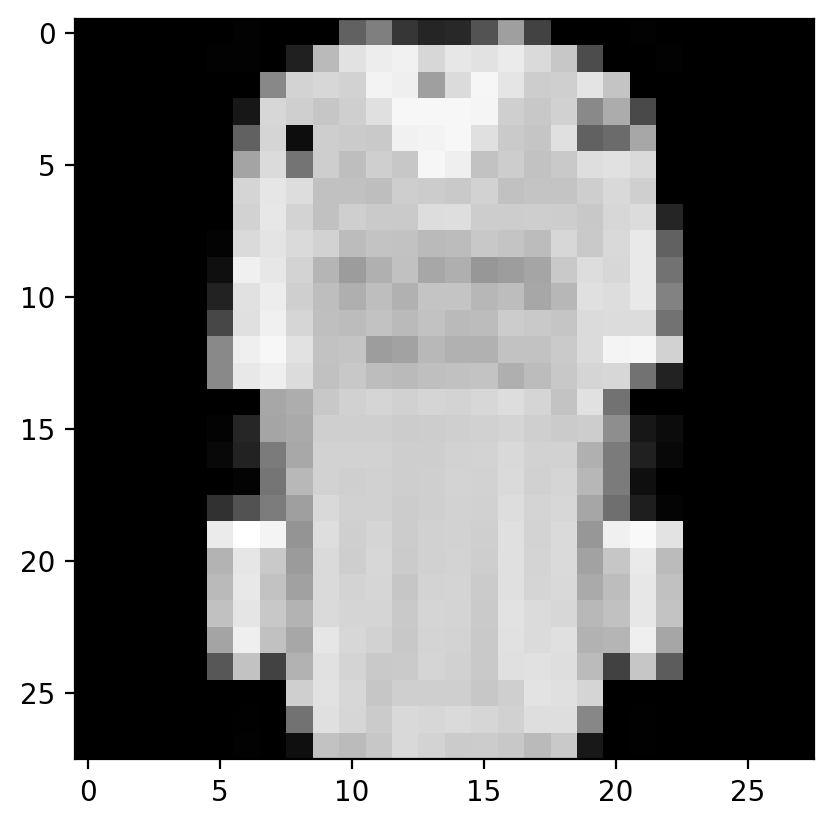

In [7]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and evaluate train/test performance

In [9]:
class MLP(nn.Module):
    #YOUR CODE HERE
    def __init__(self,dimx, hidden1, hidden2, hidden3, nlabels):
        super().__init__()
        self.output1 = nn.Linear(dimx, hidden1)
        self.output2 = nn.Linear(hidden1, hidden2)
        self.output3 = nn.Linear(hidden2, hidden3)
        self.output4 = nn.Linear(hidden3, nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [13]:
class MLP_extended(MLP):
    
    #YOUR CODE HERE
    def __init__(self,dimx, hidden1, hidden2, hidden3, nlabels, epochs = 100,lr = 0.001):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels)
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), lr = self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()
        
        self.loss_during_training = []
        
    def trainloop(self,trainloader):
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                self.optim.zero_grad()
                
                out = self.forward(images.view(images.shape[0],-1))
                
                loss = self.criterion(out, labels)
                
                running_loss += loss.item()
                
                loss.backward()
                
                self.optim.step()
    
            self.loss_during_training.append(running_loss/len(trainloader))
            
            if(e % 1 == 0):
                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                
    def evaluate(self,dataloader): #-
        accuracy = 0
        with torch.no_grad():
            for images,labels in dataloader:
                
                logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
                
                _, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            

        print("Accuracy %f" %(accuracy/len(dataloader)))

In [14]:
#YOUR CODE HERE

my_MLP = MLP_extended(784, 256, 128, 64, 10, epochs = 30, lr = 0.001)

my_MLP.trainloop(trainloader)
print('Train evaluation')
my_MLP.evaluate(trainloader)
print('Test evaluation')
my_MLP.evaluate(testloader)

Training loss after 0 epochs: 0.520586
Training loss after 1 epochs: 0.375816
Training loss after 2 epochs: 0.338439
Training loss after 3 epochs: 0.314371
Training loss after 4 epochs: 0.296048
Training loss after 5 epochs: 0.276781
Training loss after 6 epochs: 0.264880
Training loss after 7 epochs: 0.252301
Training loss after 8 epochs: 0.238971
Training loss after 9 epochs: 0.229746
Training loss after 10 epochs: 0.219662
Training loss after 11 epochs: 0.210300
Training loss after 12 epochs: 0.202327
Training loss after 13 epochs: 0.193385
Training loss after 14 epochs: 0.185078
Training loss after 15 epochs: 0.178176
Training loss after 16 epochs: 0.172151
Training loss after 17 epochs: 0.164739
Training loss after 18 epochs: 0.157399
Training loss after 19 epochs: 0.153063
Training loss after 20 epochs: 0.144058
Training loss after 21 epochs: 0.142956
Training loss after 22 epochs: 0.134892
Training loss after 23 epochs: 0.130925
Training loss after 24 epochs: 0.127262
Training l

In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [15]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]



> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs. Compute the final train/validation/test performance.

In [18]:
#YOUR CODE HERE
class MLP_extended(MLP):
    
    #YOUR CODE HERE
    def __init__(self,dimx, hidden1, hidden2, hidden3, nlabels, epochs = 100,lr = 0.001):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels)
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), lr = self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()
        
        self.loss_during_training = []
        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader,validloader = None): # Just in case there is no validation set, validloader = None
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                self.optim.zero_grad()
                
                out = self.forward(images.view(images.shape[0],-1))
                
                loss = self.criterion(out, labels)
                
                running_loss += loss.item()
                
                loss.backward()
                
                self.optim.step()
    
            self.loss_during_training.append(running_loss/len(trainloader))
            if validloader is not None:
                valid_loss = 0.
                with torch.no_grad():
                    for images, labels in validloader:
                        out = self.forward(images.view(images.shape[0],-1))
                        loss = self.criterion(out, labels)
                        valid_loss += loss.item()
                self.valid_loss_during_training.append(valid_loss/len(validloader))
            if(e % 1 == 0):
                print(f'-- Epoch {e} --')
                print("Training loss: %f" 
                      %(self.loss_during_training[-1]))
                
                if validloader is not None:
                    print("Validation loss: %f" 
                          %(self.valid_loss_during_training[-1]))
                
    def evaluate(self,dataloader): #-
        accuracy = 0
        with torch.no_grad():
            for images,labels in dataloader:
                
                logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
                
                _, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            

        print("Accuracy %f" %(accuracy/len(dataloader)))

In [19]:
#YOUR CODE HERE
my_MLP_valid = MLP_extended(784, 256, 128, 64, 10, epochs = 30, lr = 0.001)

my_MLP_valid.trainloop(trainloader,validloader)
print('Train evaluation')
my_MLP_valid.evaluate(trainloader)
print('Test evaluation')
my_MLP_valid.evaluate(testloader)

-- Epoch 0 --
Training loss: 0.551709
Validation loss: 0.487310
-- Epoch 1 --
Training loss: 0.390340
Validation loss: 0.387626
-- Epoch 2 --
Training loss: 0.352893
Validation loss: 0.370174
-- Epoch 3 --
Training loss: 0.324783
Validation loss: 0.352980
-- Epoch 4 --
Training loss: 0.306172
Validation loss: 0.344229
-- Epoch 5 --
Training loss: 0.288349
Validation loss: 0.375172
-- Epoch 6 --
Training loss: 0.275702
Validation loss: 0.317502
-- Epoch 7 --
Training loss: 0.258418
Validation loss: 0.330595
-- Epoch 8 --
Training loss: 0.247148
Validation loss: 0.335797
-- Epoch 9 --
Training loss: 0.235595
Validation loss: 0.316700
-- Epoch 10 --
Training loss: 0.225004
Validation loss: 0.326890
-- Epoch 11 --
Training loss: 0.214423
Validation loss: 0.329962
-- Epoch 12 --
Training loss: 0.208030
Validation loss: 0.339264
-- Epoch 13 --
Training loss: 0.197510
Validation loss: 0.339249
-- Epoch 14 --
Training loss: 0.187333
Validation loss: 0.340021
-- Epoch 15 --
Training loss: 0.181

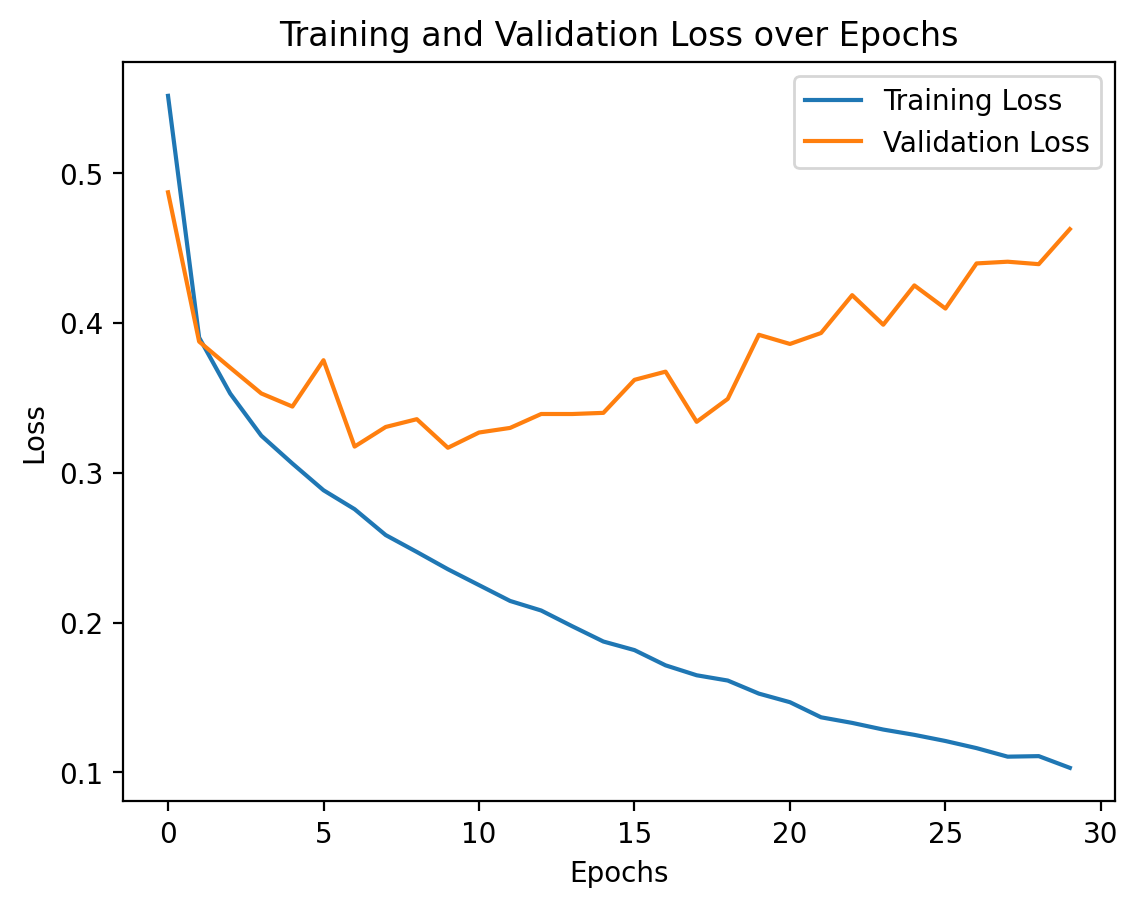

In [20]:
#YOUR CODE HERE

plt.plot(my_MLP_valid.loss_during_training, label="Training Loss")
plt.plot(my_MLP_valid.valid_loss_during_training, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

-- Epoch 0 --
Training loss: 0.555688
Validation loss: 0.432815
-- Epoch 1 --
Training loss: 0.394295
Validation loss: 0.369578
-- Epoch 2 --
Training loss: 0.351835
Validation loss: 0.384490
-- Epoch 3 --
Training loss: 0.326040
Validation loss: 0.338436
-- Epoch 4 --
Training loss: 0.307751
Validation loss: 0.330455
-- Epoch 5 --
Training loss: 0.287432
Validation loss: 0.334934
-- Epoch 6 --
Training loss: 0.270799
Validation loss: 0.339390
-- Epoch 7 --
Training loss: 0.255028
Validation loss: 0.383029
Train evaluation
Accuracy 0.891113
Validate evaluation
Accuracy 0.865403
Test evaluation
Accuracy 0.857185


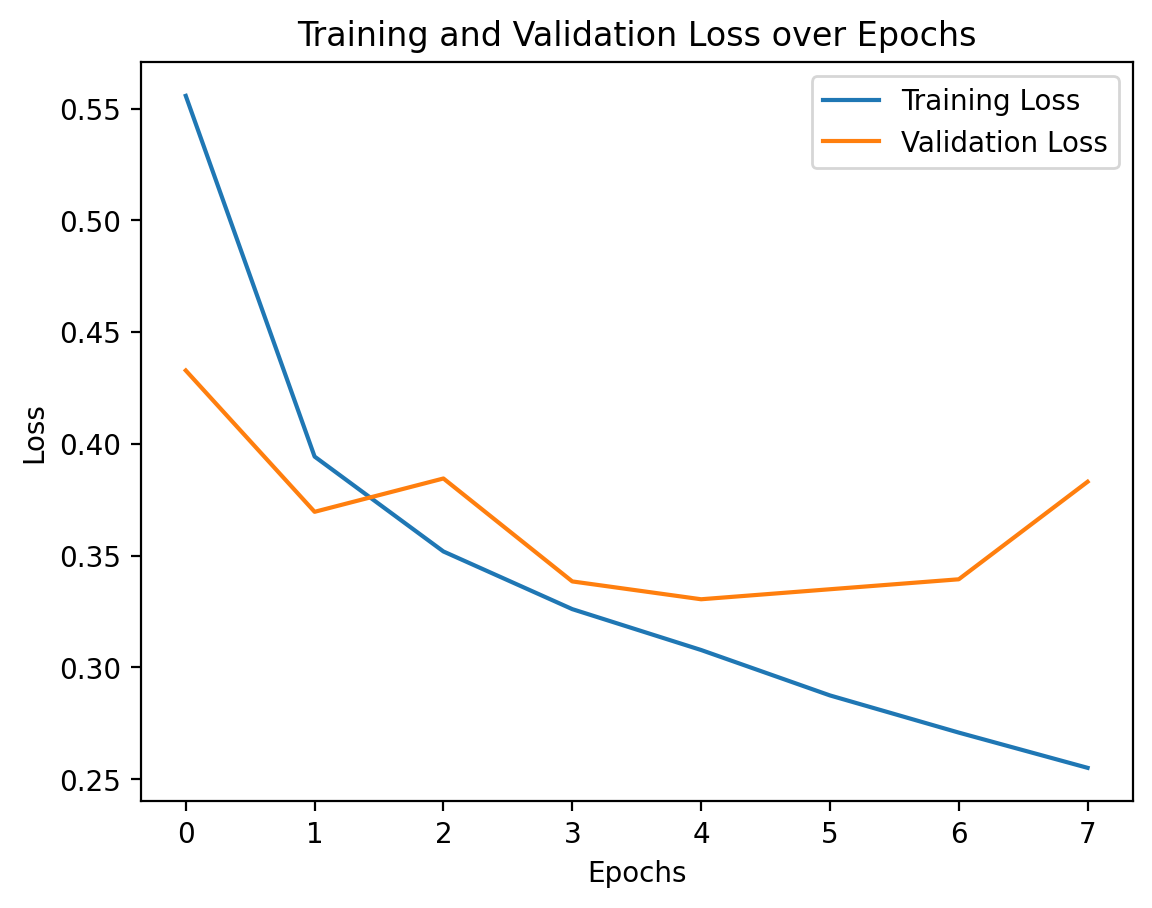

In [25]:
#YOUR CODE HERE

# Starts to grow after 8 epochs, so the training should stop there
my_MLP_valid = MLP_extended(784, 256, 128, 64, 10, epochs = 8 , lr = 0.001)

my_MLP_valid.trainloop(trainloader,validloader)
print('Train evaluation')
my_MLP_valid.evaluate(trainloader)
print('Validate evaluation')
my_MLP_valid.evaluate(validloader)
print('Test evaluation')
my_MLP_valid.evaluate(testloader)

plt.plot(my_MLP_valid.loss_during_training, label="Training Loss")
plt.plot(my_MLP_valid.valid_loss_during_training, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modify the extended class to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [28]:
class MLPdrop(nn.Module):
    
    #YOUR CODE HERE
    def __init__(self,dimx, hidden1, hidden2, hidden3, nlabels, dropout = 0.2):
        super().__init__()
        self.output1 = nn.Linear(dimx, hidden1)
        self.output2 = nn.Linear(hidden1, hidden2)
        self.output3 = nn.Linear(hidden2, hidden3)
        self.output4 = nn.Linear(hidden3, nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        self.dropout = nn.Dropout(p = dropout)
    
    def forward(self, x):
        
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [29]:
class MLPdrop_extended(MLPdrop):
    
    #YOUR CODE HERE
    
    def __init__(self,dimx, hidden1, hidden2, hidden3, nlabels, epochs = 100,lr = 0.001, dropout = 0.2):
        super().__init__(dimx, hidden1, hidden2, hidden3, nlabels, dropout)
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), lr = self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()
        
        self.loss_during_training = []
        self.valid_loss_during_training = []
    
    def trainloop(self,trainloader,validloader = None):
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                self.train() # To activate the dropout
                
                self.optim.zero_grad()
                
                out = self.forward(images.view(images.shape[0],-1))
                
                loss = self.criterion(out, labels)
                
                running_loss += loss.item()
                
                loss.backward()
                
                self.optim.step()
    
            self.loss_during_training.append(running_loss/len(trainloader))
            if validloader is not None:
                
                self.eval() # To deactivate the dropout
                
                valid_loss = 0.
                with torch.no_grad():
                    for images, labels in validloader:
                        out = self.forward(images.view(images.shape[0],-1))
                        loss = self.criterion(out, labels)
                        valid_loss += loss.item()
                self.valid_loss_during_training.append(valid_loss/len(validloader))
    
            if(e % 1 == 0):
                print(f'-- Epoch {e} --')
                print("Training loss: %f" 
                      %(self.loss_during_training[-1]))
                
                if validloader is not None:
                    print("Validation loss: %f" 
                          %(self.valid_loss_during_training[-1]))
    def evaluate(self,dataloader):
        accuracy = 0
        with torch.no_grad():
            for images,labels in dataloader:
                
                logprobs = self.forward(images.view(images.shape[0], -1))
                
                _, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            

        print("Accuracy %f" %(accuracy/len(dataloader)))
                    

-- Epoch 0 --
Training loss: 0.639790
Validation loss: 0.436880
-- Epoch 1 --
Training loss: 0.458165
Validation loss: 0.399688
-- Epoch 2 --
Training loss: 0.415323
Validation loss: 0.377230
-- Epoch 3 --
Training loss: 0.388848
Validation loss: 0.392143
-- Epoch 4 --
Training loss: 0.369818
Validation loss: 0.377888
-- Epoch 5 --
Training loss: 0.353892
Validation loss: 0.344640
-- Epoch 6 --
Training loss: 0.342785
Validation loss: 0.357780
-- Epoch 7 --
Training loss: 0.326411
Validation loss: 0.345471
-- Epoch 8 --
Training loss: 0.321477
Validation loss: 0.331649
-- Epoch 9 --
Training loss: 0.307290
Validation loss: 0.333003
-- Epoch 10 --
Training loss: 0.300128
Validation loss: 0.328973
-- Epoch 11 --
Training loss: 0.297956
Validation loss: 0.337022
-- Epoch 12 --
Training loss: 0.289947
Validation loss: 0.327863
-- Epoch 13 --
Training loss: 0.283352
Validation loss: 0.318884
-- Epoch 14 --
Training loss: 0.275466
Validation loss: 0.326047
-- Epoch 15 --
Training loss: 0.271

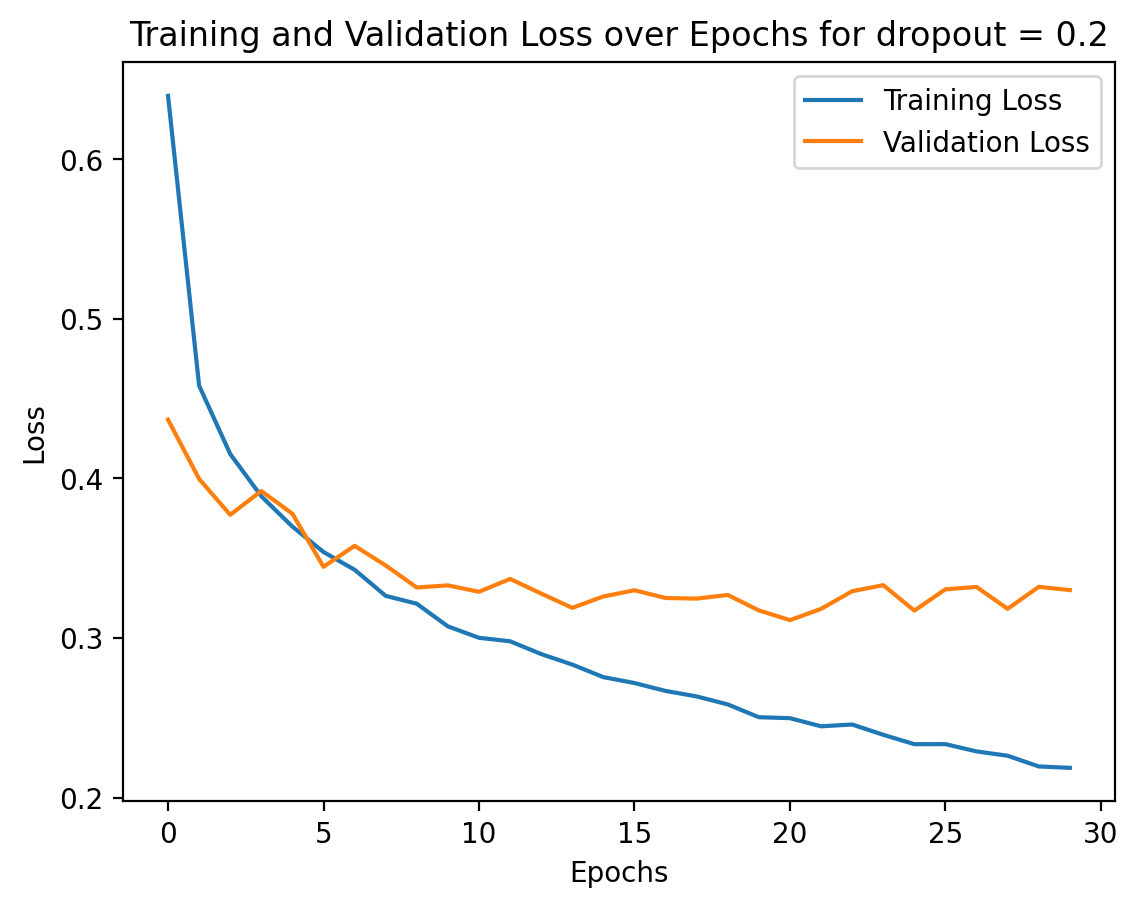

In [31]:
#YOUR CODE HERE

my_MLP_drop = MLPdrop_extended(dimx = 784, hidden1 = 256, hidden2 = 128, hidden3 = 64, nlabels = 10, epochs = 30, lr = 0.001, dropout = 0.2)

my_MLP_drop.trainloop(trainloader,validloader)
print('Train evaluation')
my_MLP_drop.evaluate(trainloader)
print('Validate evaluation')
my_MLP_drop.evaluate(validloader)
print('Test evaluation')
my_MLP_drop.evaluate(testloader)


plt.plot(my_MLP_drop.loss_during_training, label="Training Loss")
plt.plot(my_MLP_drop.valid_loss_during_training, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs for dropout = 0.2")
plt.legend()
plt.show()

-- Epoch 0 --
Training loss: 0.593743
Validation loss: 0.442606
-- Epoch 1 --
Training loss: 0.423537
Validation loss: 0.407887
-- Epoch 2 --
Training loss: 0.386138
Validation loss: 0.402338
-- Epoch 3 --
Training loss: 0.355672
Validation loss: 0.354474
-- Epoch 4 --
Training loss: 0.337540
Validation loss: 0.351304
-- Epoch 5 --
Training loss: 0.320311
Validation loss: 0.343341
-- Epoch 6 --
Training loss: 0.307717
Validation loss: 0.344671
-- Epoch 7 --
Training loss: 0.295414
Validation loss: 0.337365
-- Epoch 8 --
Training loss: 0.287173
Validation loss: 0.333138
-- Epoch 9 --
Training loss: 0.276427
Validation loss: 0.319905
-- Epoch 10 --
Training loss: 0.267356
Validation loss: 0.323999
-- Epoch 11 --
Training loss: 0.260740
Validation loss: 0.364767
-- Epoch 12 --
Training loss: 0.252346
Validation loss: 0.318473
-- Epoch 13 --
Training loss: 0.243975
Validation loss: 0.342739
-- Epoch 14 --
Training loss: 0.237052
Validation loss: 0.328586
-- Epoch 15 --
Training loss: 0.232

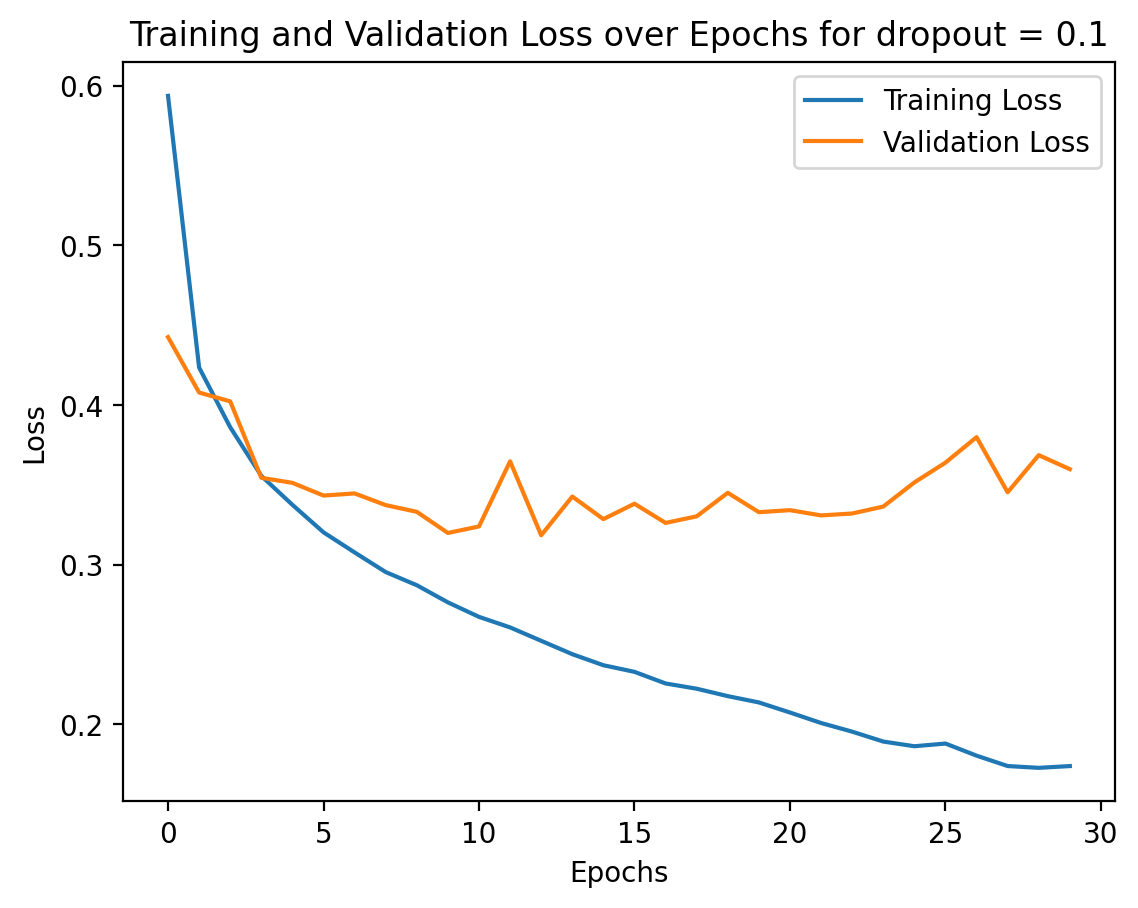

In [32]:
#YOUR CODE HERE

my_MLP_drop = MLPdrop_extended(dimx = 784, hidden1 = 256, hidden2 = 128, hidden3 = 64, nlabels = 10, epochs = 30, lr = 0.001, dropout = 0.1)

my_MLP_drop.trainloop(trainloader,validloader)
print('Train evaluation')
my_MLP_drop.evaluate(trainloader)
print('Validate evaluation')
my_MLP_drop.evaluate(validloader)
print('Test evaluation')
my_MLP_drop.evaluate(testloader)

plt.plot(my_MLP_drop.loss_during_training, label="Training Loss")
plt.plot(my_MLP_drop.valid_loss_during_training, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs for dropout = 0.1")
plt.legend()
plt.show()

-- Epoch 0 --
Training loss: 0.587416
Validation loss: 0.438823
-- Epoch 1 --
Training loss: 0.418690
Validation loss: 0.403395
-- Epoch 2 --
Training loss: 0.380054
Validation loss: 0.367772
-- Epoch 3 --
Training loss: 0.356114
Validation loss: 0.364181
-- Epoch 4 --
Training loss: 0.336878
Validation loss: 0.344378
-- Epoch 5 --
Training loss: 0.318515
Validation loss: 0.347860
-- Epoch 6 --
Training loss: 0.307729
Validation loss: 0.345173
-- Epoch 7 --
Training loss: 0.296131
Validation loss: 0.322741
-- Epoch 8 --
Training loss: 0.283156
Validation loss: 0.325313
-- Epoch 9 --
Training loss: 0.277846
Validation loss: 0.320860
-- Epoch 10 --
Training loss: 0.269906
Validation loss: 0.326678
-- Epoch 11 --
Training loss: 0.257131
Validation loss: 0.312589
-- Epoch 12 --
Training loss: 0.251551
Validation loss: 0.339768
-- Epoch 13 --
Training loss: 0.243895
Validation loss: 0.338977
-- Epoch 14 --
Training loss: 0.239383
Validation loss: 0.332317
-- Epoch 15 --
Training loss: 0.233

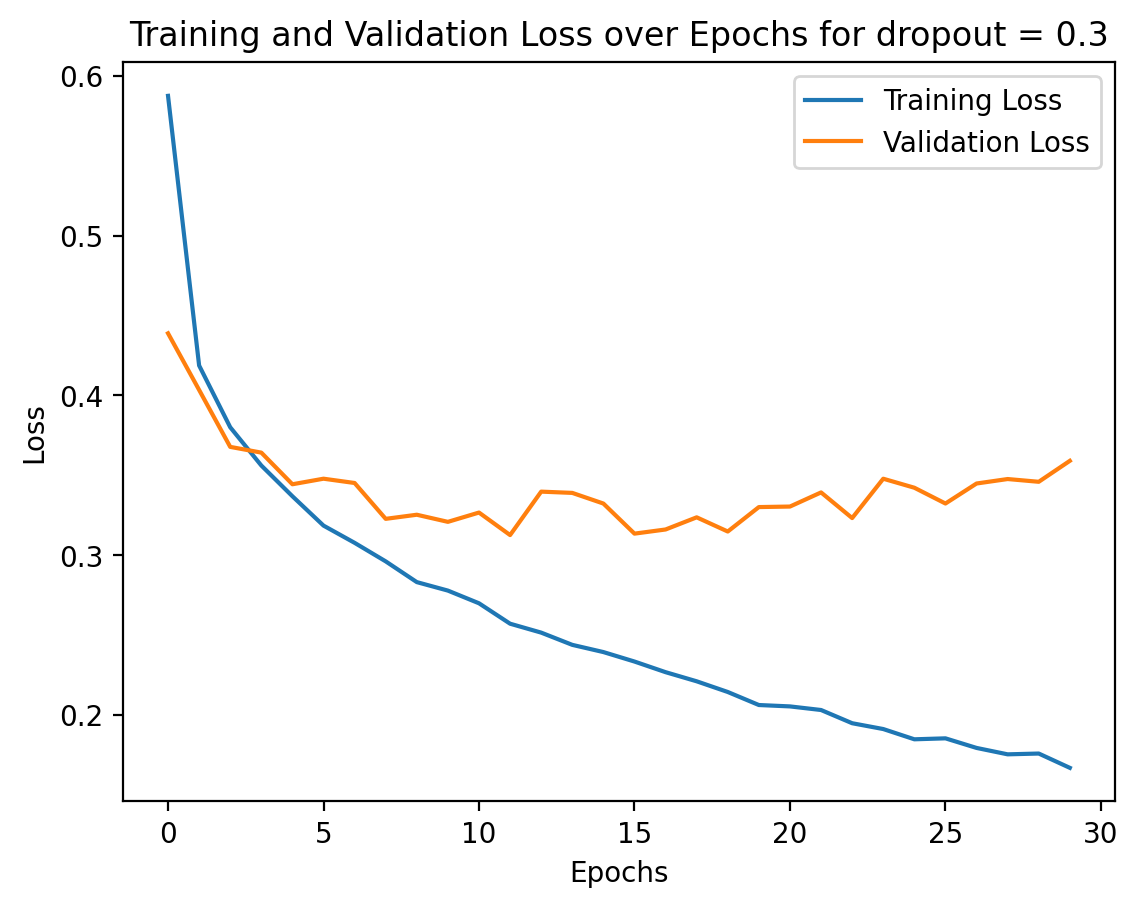

In [33]:
#YOUR CODE HERE

my_MLP_drop = MLPdrop_extended(dimx = 784, hidden1 = 256, hidden2 = 128, hidden3 = 64, nlabels = 10, epochs = 30, lr = 0.001, dropout = 0.1)

my_MLP_drop.trainloop(trainloader,validloader)
print('Train evaluation')
my_MLP_drop.evaluate(trainloader)
print('Validate evaluation')
my_MLP_drop.evaluate(validloader)
print('Test evaluation')
my_MLP_drop.evaluate(testloader)

plt.plot(my_MLP_drop.loss_during_training, label="Training Loss")
plt.plot(my_MLP_drop.valid_loss_during_training, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs for dropout = 0.3")
plt.legend()
plt.show()